In [1]:
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [2]:
df = pd.read_csv('train_preprocess.tsv.txt', sep='\t', names=['tweet','HS'])

In [3]:
df.HS.value_counts()

positive    6416
negative    3436
neutral     1148
Name: HS, dtype: int64

In [2]:
import re

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    string = re.sub("[,]", " ,", string)
    string = re.sub("[.]", " .", string)
    string = re.sub("[?]", " ? ", string)
    string = re.sub("[!]", " !", string)
    return string

In [5]:
df['tweet_clean'] = df.tweet.apply(cleansing)

In [6]:
neg = df.loc[df['HS'] == 'negative'].tweet_clean.tolist()
neu = df.loc[df['HS'] == 'neutral'].tweet_clean.tolist()
pos = df.loc[df['HS'] == 'positive'].tweet_clean.tolist()

neg_label = df.loc[df['HS'] == 'negative'].HS.tolist()
neu_label = df.loc[df['HS'] == 'neutral'].HS.tolist()
pos_label = df.loc[df['HS'] == 'positive'].HS.tolist()

In [7]:
total_data = neg + neu + pos
labels = neg_label + neu_label + pos_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data 11000


In [8]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.p', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer done")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.p', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad done")

tokenizer done
x_pad done


In [9]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.p', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_labels done')

y_labels done


In [4]:
file = open('x_pad_sequences.p', 'rb')
X = pickle.load(file)
file.close()

file = open('y_labels.p', 'rb')
Y = pickle.load(file)
file.close()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=True)

In [12]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/10
880/880 [==============================] - 236s 258ms/step - loss: 0.4490 - accuracy: 0.8230 - val_loss: 0.3600 - val_accuracy: 0.8705
Epoch 2/10
880/880 [==============================] - 237s 269ms/step - loss: 0.1902 - accuracy: 0.9325 - val_loss: 0.3598 - val_accuracy: 0.8605
Epoch 2: early stopping


In [13]:
# embed_dim = 100
# units = 64
# max_features = 100000

# model = Sequential()
# model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
# model.add(LSTM(units, dropout=0.2))
# model.add(Dense(3,activation='softmax'))
# model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
# print(model.summary())

# adam = optimizers.Adam(lr = 0.001)
# model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
# # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

In [14]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('pat')
print(matrix_test)

69/69 [==============================] - 4s 24ms/step
pat
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       704
           1       0.88      0.73      0.80       222
           2       0.87      0.93      0.90      1274

    accuracy                           0.86      2200
   macro avg       0.86      0.81      0.83      2200
weighted avg       0.86      0.86      0.86      2200



In [31]:
#Cross Validation Percobaan 4
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

y = Y

#
embed_dim = 100
#dimensi matrix
units = 64

for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]
    
    data_test = X[data[1]]
    target_test = y[data[1]]
    
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    #dense = jumlah output (negative, positive, neutral)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam , metrics = ['accuracy'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test,y_test), verbose=0, callbacks=[es])
    
    predictions = model.predict(X_test)
    y_pred = predictions
    model.save("model{}.h5".format(iteration))
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 3s 18ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       704
           1       0.89      0.72      0.79       222
           2       0.87      0.94      0.90      1274

    accuracy                           0.86      2200
   macro avg       0.86      0.81      0.83      2200
weighted avg       0.86      0.86      0.86      2200



69/69 [==============================] - 4s 34ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       704
           1       0.68      0.88      0.77       222
           2       0.92      0.89      0.91      1274

    accuracy                           0.86      2200
   macro avg       0.81      0.86      0.83      2200
weighted avg       0.87      0.86      0.86      2200



69/69 [==============================] - 2s 22ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       704
           1       0.79      0.84      0.81       222
           2       0.91      0.90      0.91      1274

    accuracy                           0.87      2200
   macro avg       0.84      0.85      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 5s 36ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       704
           1       0.82      0.77      0.80       222
           2       0.90      0.91      0.91      1274

    accuracy                           0.87      2200
   macro avg       0.85      0.83      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 2s 21ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       704
           1       0.90      0.67      0.77       222
           2       0.88      0.92      0.90      1274

    accuracy                           0.86      2200
   macro avg       0.86      0.80      0.82      2200
weighted avg       0.86      0.86      0.86      2200




Rata-rata Accuracy:  0.8623636363636363


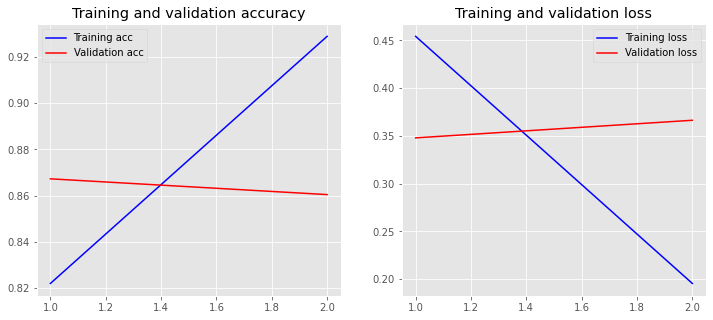

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

#overfitting coba ganti epoch 20, early stopping di matiin
#overfitting karena metode LSTM tidak cocok dengan data epoch atau data terlalu sederhana untuk model yang kompleks
#underfitting karena data kurang banyak dan epoch nya kurang
#earlystopping saat epoch validation lebih kecil di banding training

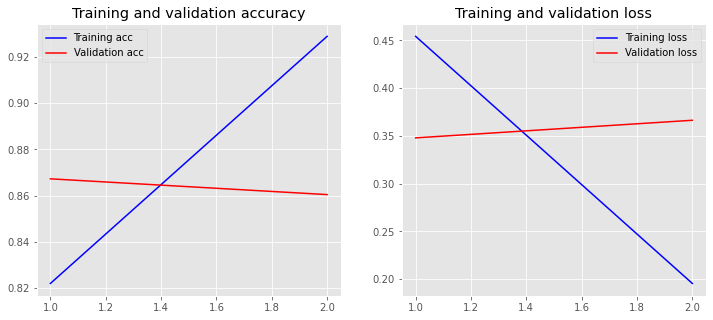

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [9]:
#Cross Validation Percobaan 3
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

max_features = 100000

# kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
Y

y = Y

#
embed_dim = 100
#dimensi matrix
units = 64

    
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
#dense = jumlah output (negative, positive, neutral)
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  
adam = optimizers.Adam(lr = 0.05)
model.compile(loss = 'categorical_crossentropy', optimizer = adam , metrics = ['accuracy'])
   
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test,y_test), verbose=0)
   
predictions = model.predict(X_test)
y_pred = predictions
    
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print("======================================================")

print(accuracy)
accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       704
           1       0.75      0.79      0.77       222
           2       0.91      0.91      0.91      1274

    accuracy                           0.87      2200
   macro avg       0.83      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200

0.87



Rata-rata Accuracy:  0.87


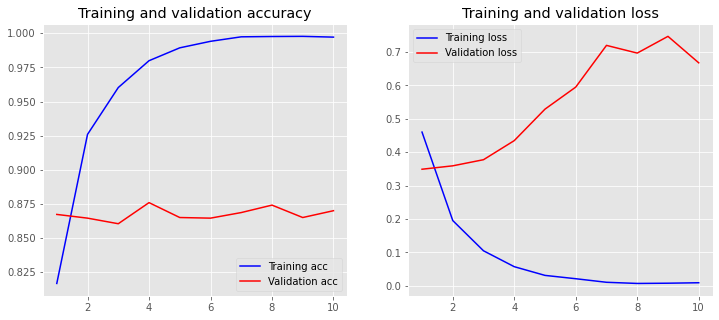

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [5]:
import re
from keras.models import load_model



In [24]:
input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    string = re.sub("[,]", " ,", string)
    string = re.sub("[.]", " .", string)
    string = re.sub("[?]", " ? ", string)
    string = re.sub("[!]", " !", string)
    return string

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model5.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

1/1 [==============================] - 1s 589ms/step
Text:   rasa syukur  cukup  
Sentiment:  positive
